# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [5]:
# model_name = "mono_640x192"
model_name = "mono+stereo_1024x320"
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()
feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']


## Loading the test image and preprocessing

In [19]:
# image_path = "assets/test_image.jpg"
# image_path = "/data/cheng443/kitti/kitti_data/2011_09_30/2011_09_30_drive_0020_sync/image_02/data/0000000017.png"
image_path = "/home/cheng443/projects/Monodepth/Monodepth2_official/assets/imageTest/simulation_no_shadow3.png"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

print("original size (w,h): (%d, %d)" % (original_width, original_height))

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
print("Model size (w,h): (%d, %d)" % (feed_width, feed_height))

input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)


original size (w,h): (1445, 545)
Model size (w,h): (1024, 320)


## Prediction using the PyTorch model

In [20]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

(-0.5, 1444.5, 544.5, -0.5)

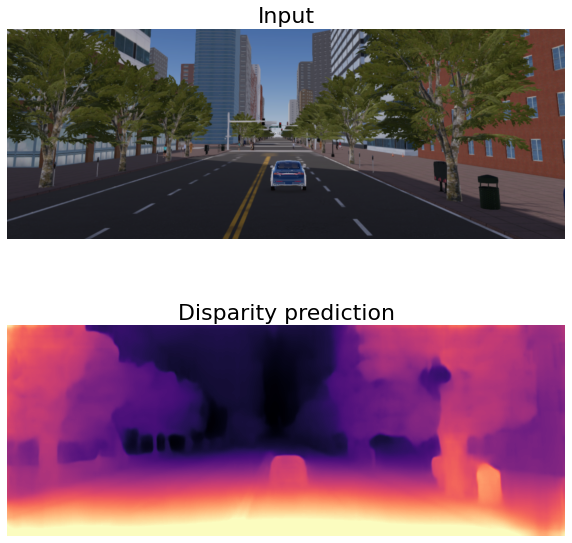

In [21]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off')

In [35]:
def predict_image_depth(image_path, encoder, depth_decoder, feed_width, feed_height):
    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size

    print("original size (w,h): (%d, %d)" % (original_width, original_height))
    print("Model size (w,h): (%d, %d)" % (feed_width, feed_height))

    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    return disp_resized_np, input_image


def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth


def compare_two_depth(path1, path2, encoder, depth_decoder, feed_width, feed_height):
    disp1, image1 = predict_image_depth(path1, encoder, depth_decoder, feed_width, feed_height)
    disp2, image2 = predict_image_depth(path2, encoder, depth_decoder, feed_width, feed_height)
    assert disp1.size == disp2.size
    scale_factor = 5.4
    depth1 = disp_to_depth(disp1, 0.1, 100)[1] * scale_factor
    depth2 = disp_to_depth(disp2, 0.1, 100)[1] * scale_factor
    diff_depth = np.abs(depth1 - depth2)
    print('Max depth difference: ', np.max(diff_depth))

    
    diff_disp = np.abs(disp1 - disp2)
    vmax = np.percentile(disp1, 95)
    
    plt.figure(figsize=(15, 10)) # width, height
    plt.subplot(321)
    plt.imshow(image1)
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(322)
    plt.imshow(image2)
    plt.title('Image 2')
    plt.axis('off')

    plt.subplot(323)
    plt.imshow(disp1, cmap='magma', vmax=vmax, vmin=0)
    plt.title('Disparity 1')
    plt.axis('off')

    plt.subplot(324)
    plt.imshow(disp2, cmap='magma', vmax=vmax, vmin=0)
    plt.title('Disparity 2')
    plt.axis('off')

    plt.subplot(325)
    plt.imshow(diff_disp, cmap='magma', vmax=vmax, vmin=0)
    plt.title('Disparity difference')
    plt.axis('off')

    plt.subplot(326)
    plt.imshow(diff_disp, cmap='magma')
    plt.title('Disparity difference (scaled)')
    plt.axis('off')



original size (w,h): (1647, 645)
Model size (w,h): (1024, 320)
original size (w,h): (1647, 645)
Model size (w,h): (1024, 320)
Max depth difference:  9.3096895


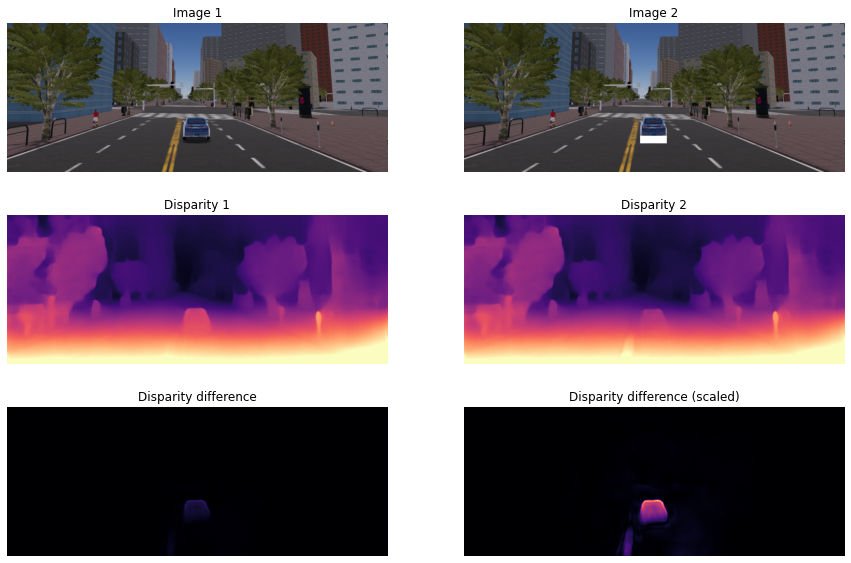

In [36]:
img1_path = '/home/cheng443/projects/Monodepth/Monodepth2_official/assets/imageTest/simulation_with_shadow4.png'
img2_path = '/home/cheng443/projects/Monodepth/Monodepth2_official/assets/imageTest/simulation_with_shadow4_block.png'

compare_two_depth(img1_path, img2_path, encoder, depth_decoder, feed_width, feed_height)

original size (w,h): (1226, 370)
Model size (w,h): (1024, 320)
original size (w,h): (1226, 370)
Model size (w,h): (1024, 320)
Max depth difference:  19.922523


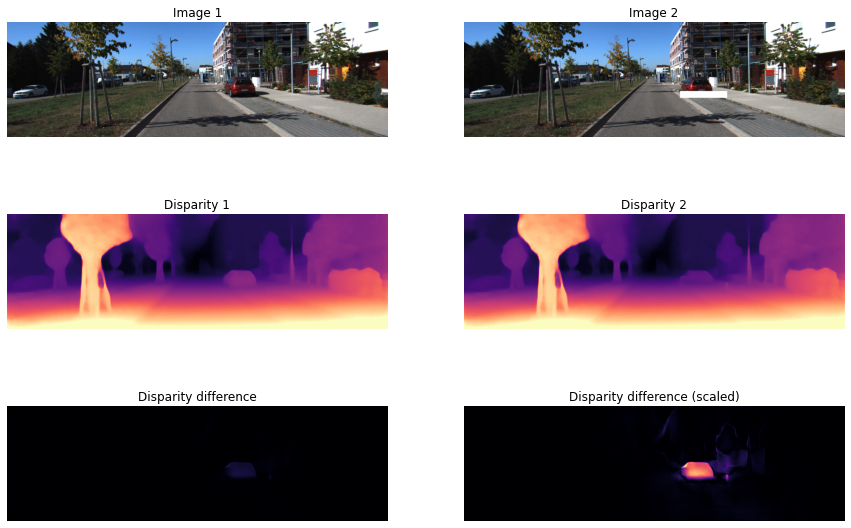

In [37]:
img1_path = '/home/cheng443/projects/Monodepth/Monodepth2_official/assets/imageTest/0000000017.png'
img2_path = '/home/cheng443/projects/Monodepth/Monodepth2_official/assets/imageTest/0000000017_block_shadow.png'

compare_two_depth(img1_path, img2_path, encoder, depth_decoder, feed_width, feed_height)